In [1]:
import os
import math
# Essential Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# Preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
# Algorithms
from minisom import MiniSom
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, r2_score
import sqlite3
from datetime import datetime
import matplotlib.dates as mdates


In [2]:
def requete_sql (requete) :
    try:
        connexion = sqlite3.connect('./data/liste_piezos.db')
        curseur = connexion.cursor()
        print("Connexion réussie à SQLite")
        curseur.execute(requete)
        connexion.commit()
        resultat = curseur.fetchall()
        curseur.close()
        connexion.close()
        print("Connexion SQLite est fermée")
        return resultat
    except sqlite3.Error as error:
        print("Erreur lors du mis à jour dans la table", error)

# Import des données
## Sélection des piezos

Récupération des codes_bss par jointure de tables dans la base de données

In [4]:
region = "IDF"

In [5]:
requete = f"""
        SELECT code_bss
        FROM data_piezo
        INNER JOIN code_region
            ON code_dpt = departement
        WHERE code_region IS '{region}'
        AND fichier_piezo IS 1
         """
data = requete_sql(requete)
code_bss = []
for code in data:
    code_bss.append(code[0]) 

Connexion réussie à SQLite
Connexion SQLite est fermée


In [6]:
len(code_bss)

71

## Construction d'un dataframe

In [7]:
directory = './data/piezo/'

# Lecture des données du premier piezo de la liste pour initialiser le dataframe
data = pd.read_csv(directory+f"{code_bss[0]}.csv", sep=";",  index_col=0, parse_dates=True)
data.rename(columns={"piezo":f"{code_bss[0]}"}, inplace=True)

custom_date_parser = lambda x: datetime.strptime(x, "%Y-%m-%d")

for file in code_bss[1:]:
    df = pd.read_csv(f"{directory+file}.csv", sep=";",  index_col=0, parse_dates=True, date_parser=custom_date_parser)
    df.rename(columns={"piezo":f"{file}"}, inplace=True)
    data = pd.merge(data,df,left_index=True, right_index=True,how='outer')

In [8]:
data

,02211X0023_CHE101,02582X0268_P11,02211X0020_F1,01833B0036_F1,02592X0036_F1,02582X0208_F1,01541X0038_F1,02606X0105_FFG1,01518X0111_GI1,01846X0361_P1,...,01531X0047_F,02173X0008_F,01534X0049_F,02606X0060_P,02605X0015_P,02922X1006_P,01865X0018_P,02565X0019_P,02202X0150_FR,02212X0021_PZ
date_mesure,,,,,,,,,,,,,,,,,,,,,
1892-01-01,NaN,NaN,NaN,NaN,NaN,NaN,-40.43,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1935-01-01,NaN,NaN,NaN,NaN,NaN,NaN,-40.43,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1965-02-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-3.0,NaN,NaN,NaN,NaN,NaN
1965-02-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1965-04-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-2.5,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-19,-59.76,NaN,-51.69,NaN,-37.39,NaN,NaN,NaN,NaN,NaN,...,20.86,-19.56,-49.97,NaN,NaN,-28.63,-20.71,-21.17,-43.67,NaN
2022-05-20,-59.77,NaN,-51.70,NaN,-37.41,NaN,NaN,NaN,NaN,NaN,...,20.86,-19.56,-49.98,NaN,NaN,-28.64,-20.73,-21.19,-43.68,NaN
2022-05-21,-59.79,NaN,-51.70,NaN,-37.42,NaN,NaN,NaN,NaN,NaN,...,20.83,-19.56,-50.01,NaN,NaN,-28.64,-20.74,-21.21,-43.69,NaN


## Visualisation des valeurs manquantes

In [9]:
# Fonction d'affichage des valeurs manquantes
def f_plot_nan (dataframe):
    f, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,6))
    sns.heatmap(dataframe.T.isna(), cmap='Blues', cbar=False)
    ax.set_title('Missing Values', fontsize=16)
    # Masquage des noms de piezo 
    ax.yaxis.set_visible(False)
    # Formatage de la date pour l'affichage
    ax.xaxis.set_ticklabels([pd.to_datetime(value).strftime('%Y') for value in ax.xaxis.get_major_formatter().func.args[0].values()])
    plt.show()

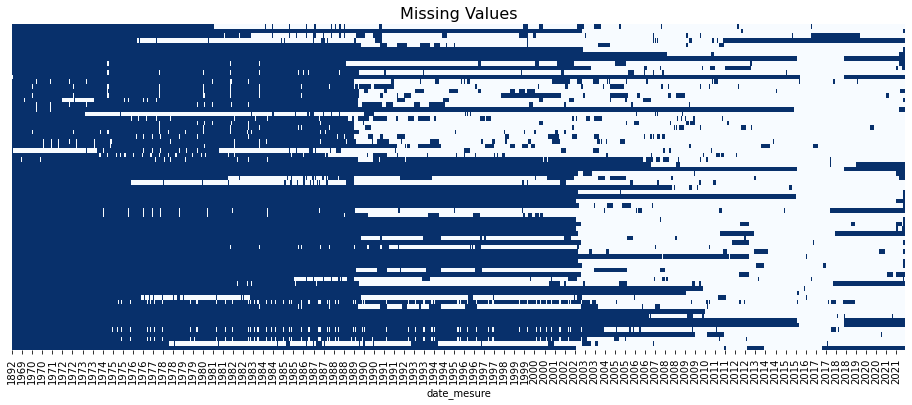

In [10]:
f_plot_nan(data)

# Traitement des données

## Rééchantillonnage à la semaine

In [11]:
data_week = pd.DataFrame(data.resample('7D').mean())

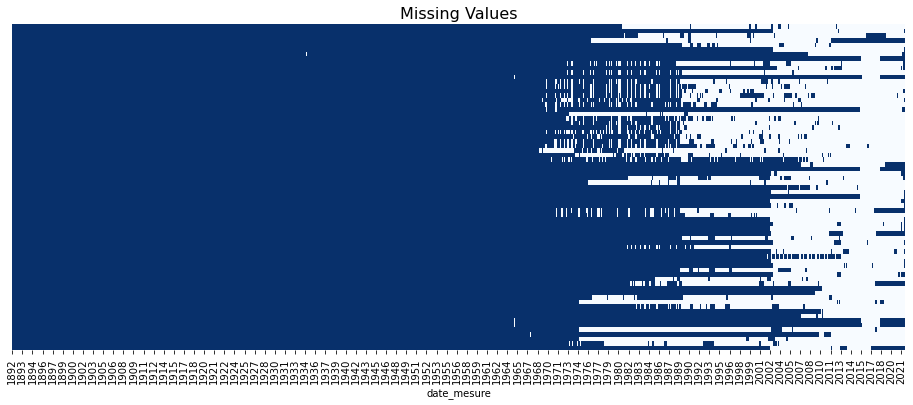

In [12]:
f_plot_nan(data_week)

In [13]:
data_week.shape

(6804, 71)

## Echelle de temps fixée après 2004 pour limiter les Nan

In [14]:
data_week_from_ = data_week.loc['01-01-2004':]

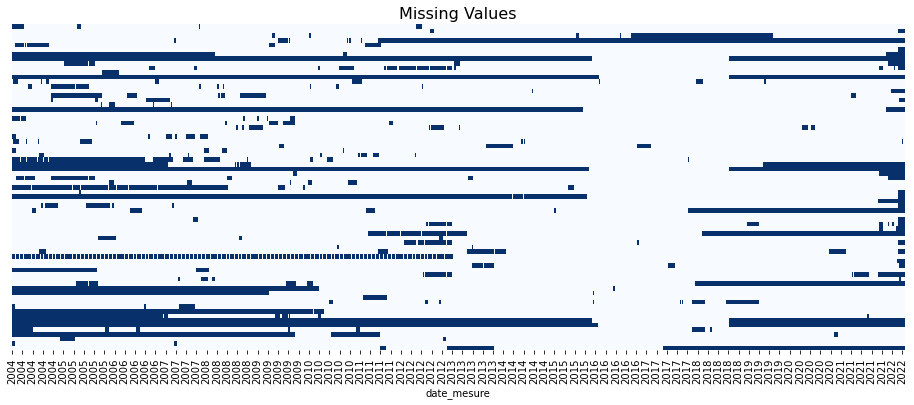

In [15]:
f_plot_nan(data_week_from_)

In [16]:
data_week_from_.shape

(960, 71)

## Suppression des valeurs abbérantes
Utilisation de la méthode IQR pour supprimer les valeurs abbérantes.
- Calcul des quartiles et de l'écart interquartile
- Suppression des valeurs < Q1 - 1.5*IQR
- Suppression des valeurs > Q3 + 1.5*IQR

In [17]:
nbre_na = data_week_from_.isna().sum().sum()
print(f"Il y a à ce stade {nbre_na} valeurs nulles dans l'ensemble du dataframe.")

Il y a à ce stade 11861 valeurs nulles dans l'ensemble du dataframe.


In [18]:
data_wo_outliers = data_week_from_.copy()

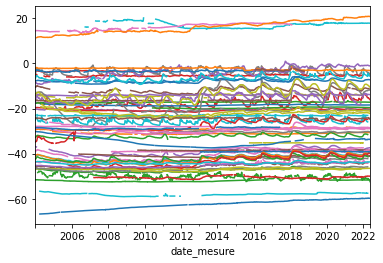

In [19]:
for piezo in data_wo_outliers.columns : 
    q1 = np.nanquantile(data_wo_outliers[f"{piezo}"], .25)
    q3 = np.nanquantile(data_wo_outliers[f"{piezo}"], .75)
    IQR = q3-q1
    data_wo_outliers.loc[data_wo_outliers[f"{piezo}"] < (q1-1.5*IQR), piezo] = np.NaN
    data_wo_outliers.loc[data_wo_outliers[f"{piezo}"] > (q3+1.5*IQR), piezo] = np.NaN
    data_wo_outliers[f"{piezo}"].plot()

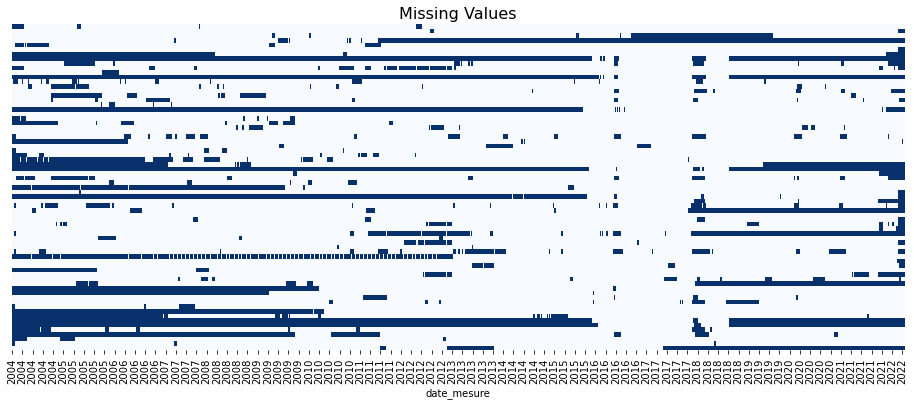

In [20]:
f_plot_nan(data_wo_outliers)

In [21]:
nbre_na_2 = data_wo_outliers.isna().sum().sum()
print(f"Il y a à ce stade {nbre_na_2} valeurs nulles dans l'ensemble du dataframe.")

Il y a à ce stade 12740 valeurs nulles dans l'ensemble du dataframe.


## Suppression des piezos avec plus de 10% de valeurs manquantes

In [22]:
# Liste des piezos avec plus de 10% de valeurs manquantes
bss_to_drop = data.loc[:,data_wo_outliers.isna().sum()>0.10*data_wo_outliers.shape[0]].columns

In [23]:
data_clean = data_wo_outliers.copy().drop(bss_to_drop, axis=1)

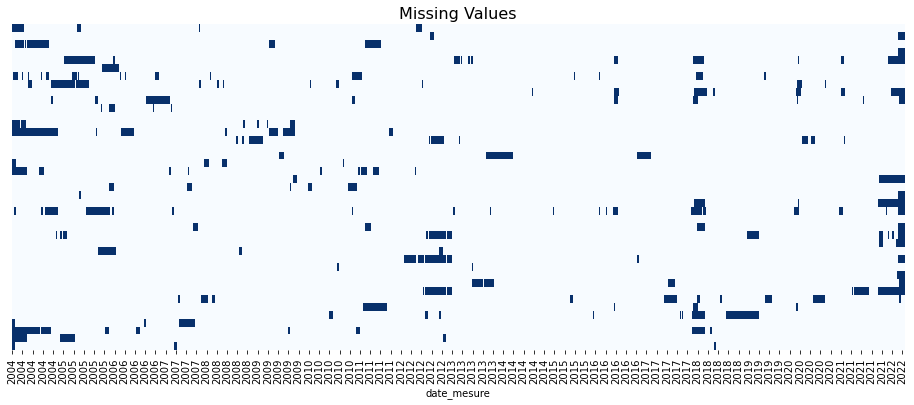

In [24]:
f_plot_nan(data_clean)

In [25]:
nbre_na_3 = data_clean.isna().sum().sum()
print(f"Il y a à ce stade {nbre_na_3} valeurs nulles dans l'ensemble du dataframe.")

Il y a à ce stade 1503 valeurs nulles dans l'ensemble du dataframe.


In [26]:
data_clean.shape

(960, 41)

## Interpolation

In [27]:
data_interpol = data_clean.copy().interpolate('linear')

In [28]:
data_interpol.shape

(960, 41)

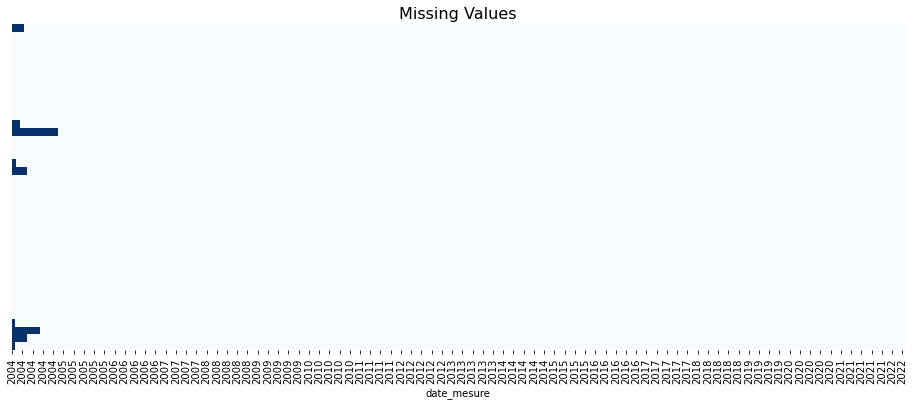

In [29]:
f_plot_nan(data_interpol)

## Réajustement des dates de début et de fin

In [30]:
debut = []
for column in data_interpol.columns:
    debut.append(data_interpol[f"{column}"].first_valid_index())
date_debut = max(debut)

In [31]:
fin = []
for column in data_interpol.columns:
    fin.append(data_interpol[f"{column}"].last_valid_index())
date_fin = min(fin)
date_fin

Timestamp('2022-05-20 00:00:00', freq='7D')

In [32]:
data_interpol = data_interpol.loc[date_debut:date_fin]

In [33]:
print(f"Nombre total de Nan : {data_interpol.isna().sum().sum()}")

Nombre total de Nan : 0


In [34]:
data_interpol.shape

(910, 41)

In [35]:
data_interpol.shape[1]

41

## Affichage des chroniques après nettoyage

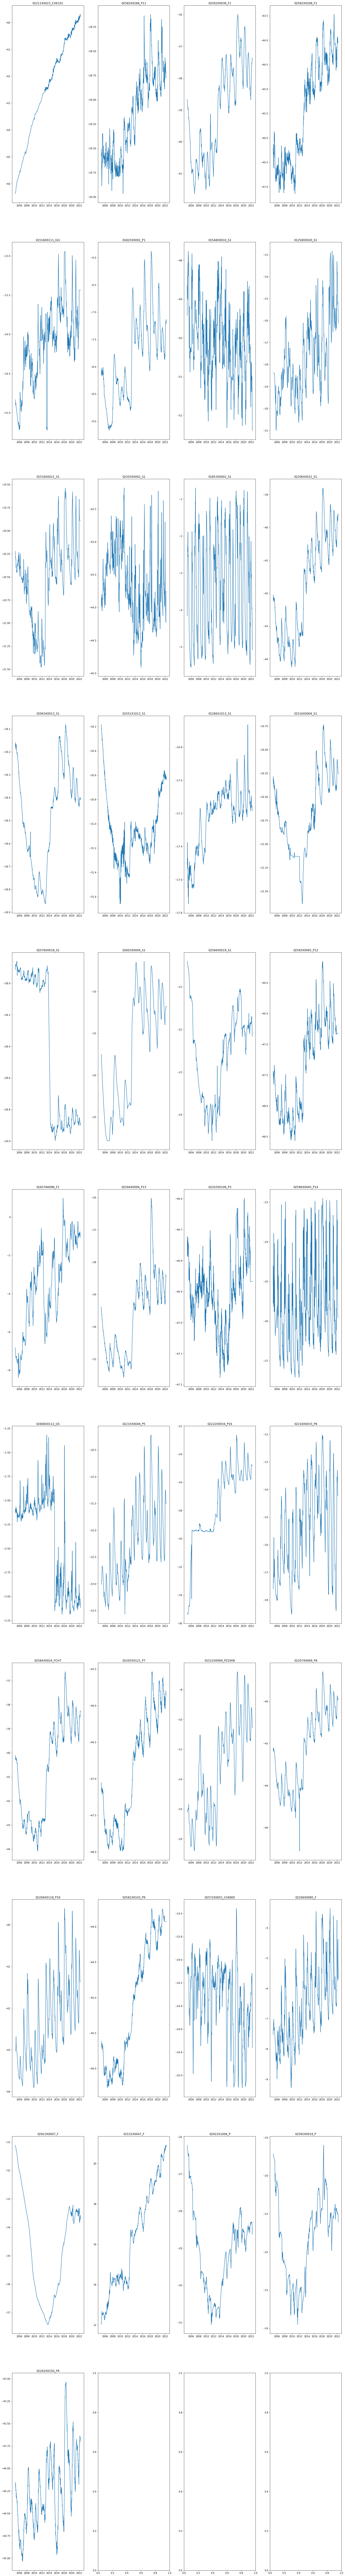

In [36]:
if data_interpol.shape[1]%4 == 0:
    nbre_lignes = data_interpol.shape[1]//4
else : 
    nbre_lignes = data_interpol.shape[1]//4 + 1

fig, axs = plt.subplots(nbre_lignes,4,figsize=(25,200))
#fig.suptitle('Series')
for i in range(nbre_lignes):
    for j in range(4):
        if i*4+j+1>data_interpol.shape[1]: # pass the others that we can't fill
            continue
        axs[i, j].plot(data_interpol.iloc[:,i*4+j])
        axs[i, j].set_title(data_interpol.columns[i*4+j])
plt.show()

## Normalisation StandardScaler

In [37]:
def scaleColumns(df):
    for col in df.columns:
        df[col] = pd.DataFrame(scaler.fit_transform(pd.DataFrame(df[col])),columns=[col], index=df.index)
    return df

In [38]:
scaler = StandardScaler()
data_norm = scaleColumns(data_interpol.copy())

In [39]:
data_norm.head()

,02211X0023_CHE101,02582X0268_P11,02592X0036_F1,02582X0208_F1,01518X0111_GI1,01825X0091_P1,01548X0010_S1,01258X0020_S1,01516X0021_S1,02203X0002_S1,...,02207X0069_P8,02206X0118_P19,02581X0103_P9,02572X0051_CHEBID,02206X0085_F,02923X0007_F,01531X0047_F,02922X1006_P,02565X0019_P,02202X0150_FR
date_mesure,,,,,,,,,,,,,,,,,,,,,
2004-12-17,-2.104491,-0.826182,0.224413,-0.721243,-1.436323,-0.396382,0.787324,-0.363223,0.648850,-0.377416,...,0.043690,-0.678337,-0.630958,0.831691,-0.780414,2.098034,-1.695706,2.692494,2.018586,0.246788
2004-12-24,-2.084298,-0.999148,0.189535,-0.753597,-1.436323,-0.407544,1.618996,-0.363857,0.541737,-0.393260,...,0.018949,-0.693065,-0.635949,0.854525,-0.648607,2.086760,-1.653979,2.668586,2.010621,0.204805
2004-12-31,-2.079638,-0.910969,0.144288,-0.830439,-1.473529,-0.258707,1.301505,-0.364491,0.507083,-0.604518,...,-0.033625,-0.694537,-0.705828,0.895626,-0.656919,2.065016,-1.653415,2.626083,2.002580,0.113842
2005-01-07,-2.076531,-0.917752,0.143346,-0.640356,-1.510735,-0.307079,1.405270,-0.365125,0.488181,-0.485685,...,-0.017389,-0.685701,-0.695845,0.895626,-0.618921,2.065016,-1.615634,2.611473,1.994539,0.162822
2005-01-14,-2.067211,-0.938101,0.141461,-0.664622,-1.576561,-0.390800,1.775418,-0.365758,0.507083,-0.498889,...,0.005032,-0.672447,-0.667561,0.799723,-0.662856,2.060989,-1.566012,2.603503,1.986498,0.197808


## Sauvegarde du dataframe en csv

In [40]:
data_norm.to_csv(f"./data/piezo_clustering/{region}.csv", sep = ";")